In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor
from xgboost import plot_importance

In [2]:
def evaluate_model(model, x, y):
    y_pred = model.predict(x)
    rmse = mean_squared_error(y, y_pred, squared=False)
    return rmse

In [3]:
def get_xgboost_model():
    model =  XGBRegressor(objective='reg:linear',
                          random_state=seed, 
                          tree_method='gpu_hist', 
                          predictor='gpu_predictor',
                          verbosity=0)
    return model

In [4]:
warnings.filterwarnings("ignore")
seed=47

In [5]:
name = "dados-historicos-partner_i-cement-CPIIE40.csv"
df_r3d_and_r7d = pd.read_csv("../../data/interim/" + "r3d_and_r7d-no-resampling-without-fillna-" + name)
df_r3d_only = pd.read_csv("../../data/interim/" + "r3d_only-no-resampling-without-fillna-" + name)
df_no_r3d_r7d = pd.read_csv("../../data/interim/" + "no-r3d-r7d-no-resampling-without-fillna-" + name)

# XGBoost Gradient

# TESTE

In [24]:
y = df_no_r3d_r7d['R28D']
x = df_no_r3d_r7d.drop(['Data/Hora', 'R28D'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = seed)       

In [25]:
params = {'n_estimators': 300, 
          'max_depth': 18, 
          'subsample': 1.0,
          'eta': 0.3,
          'colsample_bytree': 1.0,
          'gamma': 0.0, 
          'min_child_weight': 1,
          'reg_alpha': 1,
          'eval_metric':'mae'}


model =  XGBRegressor(**params,
                         objective='reg:linear',
                         random_state=seed, 
                         tree_method='gpu_hist', 
                         predictor='gpu_predictor',
                         early_stopping_rounds=200,
                         verbosity=0)
model.fit(x_train, y_train, verbose=True)
score = evaluate_model(model, x_test, y_test)
print(score)

1.7063644091546974


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

<Figure size 720x720 with 0 Axes>

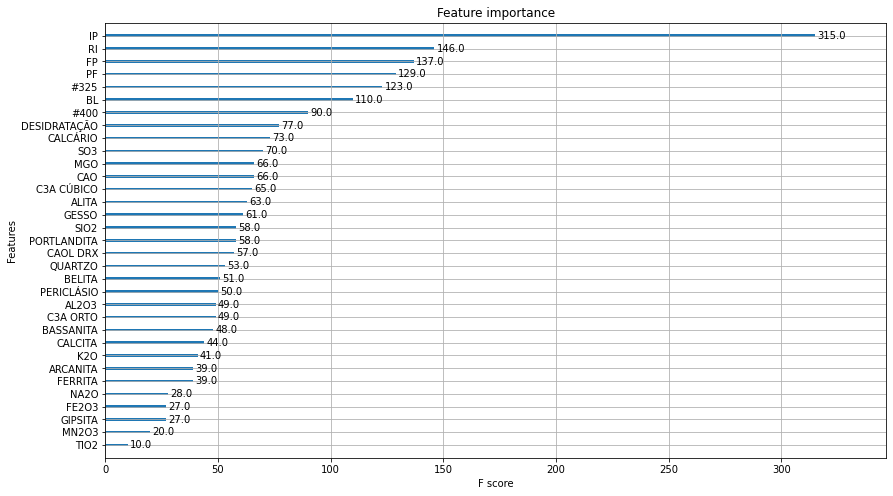

In [46]:
plt.figure(figsize=(10,10))
plt.rcParams["figure.figsize"] = (14, 8)
plot_importance(model)

In [50]:
model = get_xgboost_model()
model.fit(x_train, y_train, verbose=True)
score = evaluate_model(model, x_test, y_test)
print(score)

1.6597021264277556


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

<Figure size 720x720 with 0 Axes>

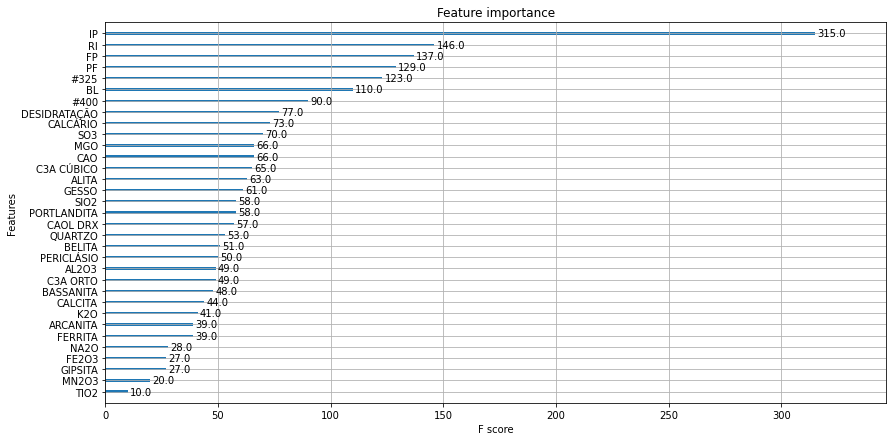

In [41]:
plt.figure(figsize=(10,10))
plt.rcParams["figure.figsize"] = (14, 7)
plot_importance(model)

# Grid Search Hyperparameters - XGBoost

In [43]:
# https://www.kaggle.com/prashant111/a-guide-on-xgboost-hyperparameters-tuning#2.-XGBoost-hyperparameters-
params = {'n_estimators' : [10, 50, 100, 200, 300],
          'max_depth' : [2, 3, 5, 10, 15, 20],
          'subsample' : [0.8, 0.9, 1.0],
          'eta' : [0.11, 0.12],
          'colsample_bytree' : [0.3, 0.4],
          'min_child_weight': [1, 2, 3, 5],
          'gamma': [0.001, 0.1, 1, 2]
         }

<h3>GridCV 1</h3>

<b>Dataset: df_no_r3d_r7d:</b> In this dataset the R3D and R7D variables are not considered.

In [6]:
y = df_no_r3d_r7d['R28D'].values
x = df_no_r3d_r7d.drop(['Data/Hora', 'R28D'], axis=1).values

In [7]:
model = XGBRegressor(objective='reg:linear',
                     random_state=seed,
                     tree_method='gpu_hist', 
                     predictor='gpu_predictor',
                     early_stopping_rounds=200, 
                     verbosity=0)
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=seed)
search = GridSearchCV(model, param_grid=params, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=cv)

import time
start = time.time()

result = search.fit(x, y)

end = time.time()
print("\nMinutes Elapsed: ", (end - start)/60)

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)


Minutes Elapsed:  123.06422835985819
Best Score: -1.7945854779989645
Best Hyperparameters: {'colsample_bytree': 0.4, 'eta': 0.12, 'gamma': 0.001, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 50, 'subsample': 0.9}


# Repeated KFold Cross validation

<h3>Experiment 1</h3>
<h4> Repeated KFold Cross Validation - df_no_r3d_r7d</h4>

<b>Dataset: df_no_r3d_r7d:</b> In this dataset the R3D and R7D variables are not considered.

In [6]:
y = df_no_r3d_r7d['R28D']
x = df_no_r3d_r7d.drop(['Data/Hora', 'R28D'], axis=1)

In [7]:
model = get_xgboost_model()
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=seed)
scores = cross_val_score(model, x, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
scores = np.abs(scores)
print('RMSE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

RMSE: 1.818 (0.221)


<h3>Plot of feature importance</h3>

1.702702803970038


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

<Figure size 720x720 with 0 Axes>

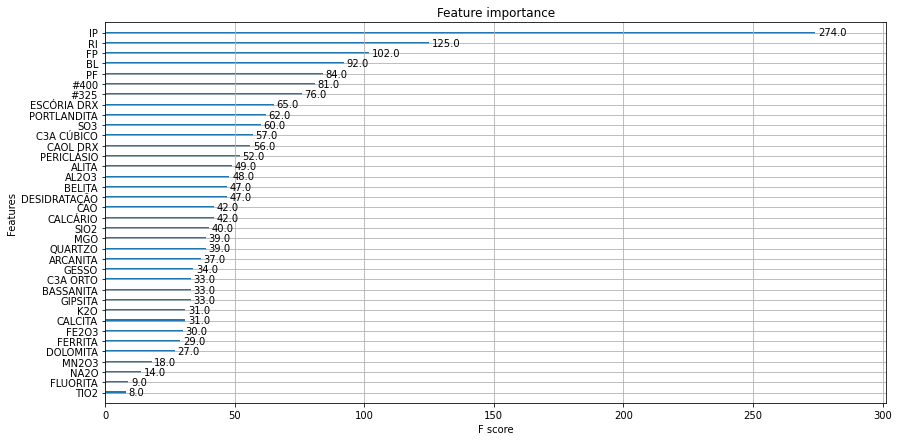

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = seed)       
model = get_xgboost_model()
model.fit(x_train, y_train, verbose=True)
score = evaluate_model(model, x_test, y_test)
print(score)
plt.figure(figsize=(10,10))
plt.rcParams["figure.figsize"] = (14, 7)
plot_importance(model)

<h3>Experiment 2</h3>
<h4> Repeated KFold Cross Validation - df_r3d-only</h4>

<b>Dataset: df_r3d-only:</b> In this dataset the R7D variable is not considered.

In [9]:
y = df_r3d_only['R28D']
x = df_r3d_only.drop(['Data/Hora', 'R28D'], axis=1)

In [10]:
model = get_xgboost_model()
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=seed)
scores = cross_val_score(model, x, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
scores = np.abs(scores)
print('RMSE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

RMSE: 1.784 (0.218)


<h3>Plot of feature importance</h3>

1.741514554477298


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

<Figure size 720x720 with 0 Axes>

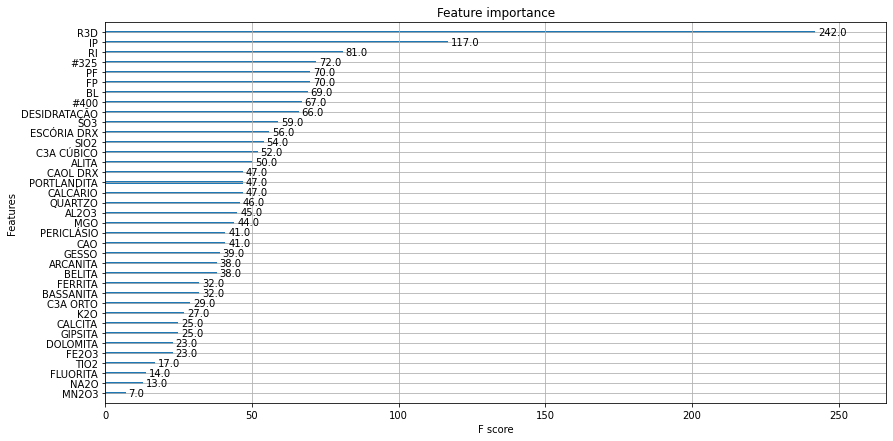

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = seed)       
model = get_xgboost_model()
model.fit(x_train, y_train, verbose=True)
score = evaluate_model(model, x_test, y_test)
print(score)
plt.figure(figsize=(10,10))
plt.rcParams["figure.figsize"] = (14, 7)
plot_importance(model)

<h3>Experiment 3</h3>
<h4> Repeated KFold Cross Validation - df_r3d-and-rd7</h4>

<b>Dataset: df_r3d_and_r7d:</b> In this dataset both R3D and R7D variables are considered.

In [12]:
y = df_r3d_and_r7d['R28D']
x = df_r3d_and_r7d.drop(['Data/Hora', 'R28D'], axis=1)

In [13]:
model = get_xgboost_model()
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=seed)
scores = cross_val_score(model, x, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
scores = np.abs(scores)
print('RMSE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

RMSE: 1.759 (0.214)


<h3>Plot of feature importance</h3>

1.6071542831223837


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

<Figure size 720x720 with 0 Axes>

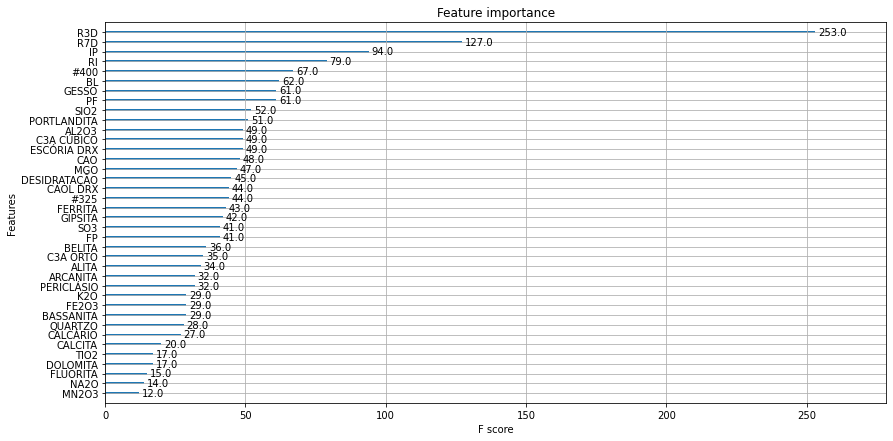

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = seed)       
model = get_xgboost_model()
model.fit(x_train, y_train, verbose=True)
score = evaluate_model(model, x_test, y_test)
print(score)
plt.figure(figsize=(10,10))
plt.rcParams["figure.figsize"] = (14, 7)
plot_importance(model)